Carles Criado Ninà

# Playing with Keras, convolutional neural networks, and the MNIST data set (part 2).

Loosely based on "How to choose CNN Architecture MNIST" (https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook).

# Recycle code from part 1

## Import libraries
Import the necessary libraries to run this notebook:

In [ ]:
from tensorflow.keras.datasets import mnist

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python import train

import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
from numpy.ma.core import floor

## Load and prepare the MNIST data set

Load de MNIST data set form Keras:

In [ ]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

11501568/11490434 [==============================] - 0s 0us/step


Show the first image and some properties:

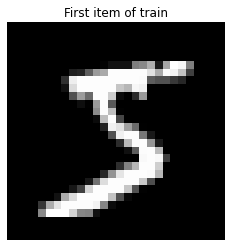

Label: 5
Shape: (28, 28)
Max/min: 255 0


In [ ]:
plt.imshow(x_train[0].reshape(28,28))
plt.axis('off')
plt.set_cmap('gray')
plt.title("First item of train")
plt.show()
print("Label:", y_train[0])
print("Shape:", x_train[0].shape)
print("Max/min:", x_train[0].max(), x_train[0].min())

Add one dimmension to the train and test data to fit the expected shape of the network input:

In [ ]:
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

Separate a validation data set from the train data set:

In [ ]:
size_val = 10000
size_train = x_train.shape[0] - size_val

x_val = x_train[size_train:]
y_val = y_train[size_train:]

x_train = x_train[:size_train]
y_train = y_train[:size_train]

We now have 50.000 cases for the train set, 10.000 cases for the validation set and 10.000 cases for the test set:

In [ ]:
print("train data shape:", x_train.shape)
print("train labels shape:", y_train.shape, "\n")

print("validation data shape:", x_val.shape)
print("validation labels shape:", y_val.shape, "\n")

print("test data shape:", x_test.shape)
print("test labels shape:", y_test.shape)

train data shape: (50000, 28, 28, 1)
train labels shape: (50000,) 

validation data shape: (10000, 28, 28, 1)
validation labels shape: (10000,) 

test data shape: (10000, 28, 28, 1)
test labels shape: (10000,)


## Prepare some reusable code

Define two layers that we will use on (almost) every model. They will take care of:
- Image preprocessing:
  - Resizing (not actually necessary in this case)
  - Rescaling
- Data augmentation:
  - Random rotation
  - Random zoom

In [ ]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(28, 28),
    layers.Rescaling(1./255),
    ], name="resize_and_rescale")

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
    ], name="data_augmentation")

# Some new reusable code

This function will take care of training every model and showing it's validation accuracy

In [ ]:
def try_models(models,
               epochs = 30,
               optimizer = "rmsprop",
               loss = "sparse_categorical_crossentropy",
               metrics = ["accuracy"],
               ):
    for model in models:
        model.compile(optimizer = optimizer,
                    loss = loss,
                    metrics = metrics)

        history = model.fit(x_train, y_train,
                            epochs = epochs,
                            batch_size = 64, 
                            validation_data = (x_val, y_val),
                            verbose = 0,
                            )
        
        val_acc = history.history["val_accuracy"]
        print("Model name: %s - Accuracy (max / last) %.5f / %.5f" % (model.name, max(val_acc), val_acc[-1]))
        val_acc.extend([0] * (epochs-len(val_acc)) ) # pad with zeros to match epochs length
        plt.plot(range(epochs), val_acc, label=model.name)

    plt.legend()
    plt.show()

# Search for the best architecture and hyperparameters

## Try different numbers of convolutional layers

- 1x (1 conv, 1 maxpool)
- 2x (1 conv, 1 maxpool)
- 3x (1 conv, 1 maxpool)
- 1x (2 conv, 1 maxpool)
- 2x (2 conv, 1 maxpool)
- 3x (2 conv, 1 maxpool)

In [ ]:
stacks = [1, 2]
filters = [32, 64, 128]
num_models = len(filters) * len(stacks)
models = [0] * num_models

for i in range(num_models):
    si = int(floor(i / 3))   # [0, 0, 0, 1, 1, 1]
    fi = i % 3 + 1           # [1, 2, 3, 1, 2, 3]

    inputs = keras.Input(shape=(28,28,1), name="inputs")
    x = resize_and_rescale(inputs)

    # stack(s) of convolutional layers
    for f in filters[:fi]:
        x = layers.Conv2D(f, 3, padding="same", activation="relu",
                          name="conv_1_"+str(f)) (x)
        if stacks[si] == 2:
            x = layers.Conv2D(f, 3, padding="same", activation="relu",
                              name="conv_2_"+str(f)) (x)
        x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu",
                          name="strides_"+str(f)) (x)
    
    x = layers.Flatten(name="flatten") (x)
    outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

    name = str(stacks[si]) + str(filters[:fi])
    name = name.replace(", ", "-")
    name = name.replace("[", "x")
    name = name.replace("]", "")

    models[i] = keras.Model(inputs=inputs, outputs=outputs, name=name)
    print("Model name:", models[i].name, "- Number of parameters:", models[i].count_params())

Model name: 1x32 - Number of parameters: 72298
Model name: 1x32-64 - Number of parameters: 96362
Model name: 1x32-64-128 - Number of parameters: 306922
Model name: 2x32 - Number of parameters: 81546
Model name: 2x32-64 - Number of parameters: 142538
Model name: 2x32-64-128 - Number of parameters: 500682


Model name: 1x32 - Accuracy (max / last) 0.98680 / 0.98440
Model name: 1x32-64 - Accuracy (max / last) 0.99070 / 0.98830
Model name: 1x32-64-128 - Accuracy (max / last) 0.99230 / 0.99090
Model name: 2x32 - Accuracy (max / last) 0.98940 / 0.98790
Model name: 2x32-64 - Accuracy (max / last) 0.99150 / 0.98930
Model name: 2x32-64-128 - Accuracy (max / last) 0.99270 / 0.99020


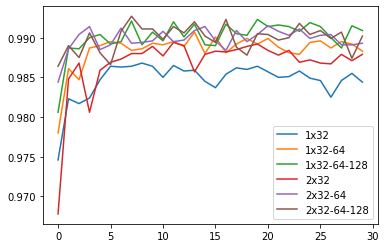

In [ ]:
try_models(models)

We achieve the best accuracy with the 2x32-64-128 model (3 stacks of 2 convolutional layers). But the model 2x32-64-128 (3 single convolutional layers) achives a similar accuracy taking less parameters.

Also, the model 2x32-64 (only 2 stacks) also achieves a similar accuracy but takes much more less parameters than the other two. It seems like a good trade off. We'll continue with this architecture.

## Try different numbers of filters

Next, we can try different numbers of filters for the convolutional layers:
- 8, 16
- 16, 32
- 24, 48
- 32, 64
- 48, 96
- 64, 128

In [ ]:
filters = [8, 16, 24, 32, 48, 64]
num_models = len(filters)
models = [0] * num_models

for i, f in enumerate(filters):

    inputs = keras.Input(shape=(28,28,1), name="inputs")
    x = resize_and_rescale(inputs)

    for j in range(1,3):
        x = layers.Conv2D(j*f, 3, padding="same", activation="relu",
                        name="conv_1_"+str(j*f)) (x)
        x = layers.Conv2D(j*f, 3, padding="same", activation="relu",
                        name="conv_2_"+str(j*f)) (x)
        x = layers.Conv2D(j*f, 3, padding="same", strides=2, activation="relu",
                        name="strides_"+str(j*f)) (x)

    x = layers.Flatten(name="flatten") (x)
    outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

    name = str(f) + "-" + str(f*2)

    models[i] = keras.Model(inputs=inputs, outputs=outputs, name=name)
    print("Model name:", models[i].name, "- Number of parameters:", models[i].count_params())

Model name: 8-16 - Number of parameters: 14906
Model name: 16-32 - Number of parameters: 43626
Model name: 24-48 - Number of parameters: 86170
Model name: 32-64 - Number of parameters: 142538
Model name: 48-96 - Number of parameters: 296746
Model name: 64-128 - Number of parameters: 506250


Model name: 8-16 - Accuracy (max / last) 0.99000 / 0.98950
Model name: 16-32 - Accuracy (max / last) 0.99140 / 0.98970
Model name: 24-48 - Accuracy (max / last) 0.99160 / 0.99050
Model name: 32-64 - Accuracy (max / last) 0.99240 / 0.99150
Model name: 48-96 - Accuracy (max / last) 0.99230 / 0.99040
Model name: 64-128 - Accuracy (max / last) 0.99190 / 0.99150


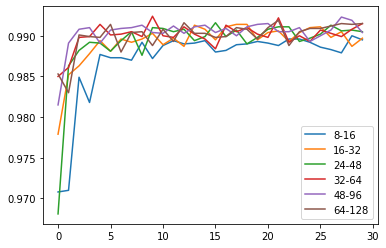

In [ ]:
try_models(models)

We achieve the best accuracy with the model with 32 and 64 filters.

## Try adding a hidden dense layer

Now we'll try adding a hidden dense layer with different numbers of neurons:
- 0
- 32
- 64
- 128
- 256

In [ ]:
filters = [32, 64]
hidden_layers = [0, 32, 64, 128, 256]
num_models = len(hidden_layers)
models = [0] * num_models

for i, h in enumerate(hidden_layers):

    inputs = keras.Input(shape=(28,28,1), name="inputs")
    x = resize_and_rescale(inputs)

    for f in filters:
        x = layers.Conv2D(f, 3, padding="same", activation="relu",
                        name="conv_1_"+str(f)) (x)
        x = layers.Conv2D(f, 3, padding="same", activation="relu",
                        name="conv_2_"+str(f)) (x)
        x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu",
                        name="strides_"+str(f)) (x)
    x = layers.Flatten(name="flatten") (x)

    # hidden layer
    if h > 0:
        x = layers.Dense(h, activation="relu", name="hidden") (x)

    outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

    name = str(h)
    models[i] = keras.Model(inputs=inputs, outputs=outputs, name=name)
    print("Model name:", models[i].name, "- Number of parameters:", models[i].count_params())

Model name: 0 - Number of parameters: 142538
Model name: 32 - Number of parameters: 211882
Model name: 64 - Number of parameters: 312586
Model name: 128 - Number of parameters: 513994
Model name: 256 - Number of parameters: 916810


Model name: 0 - Accuracy (max / last) 0.99220 / 0.99040
Model name: 32 - Accuracy (max / last) 0.99220 / 0.99200
Model name: 64 - Accuracy (max / last) 0.99320 / 0.99060
Model name: 128 - Accuracy (max / last) 0.99250 / 0.99200
Model name: 256 - Accuracy (max / last) 0.99250 / 0.99070


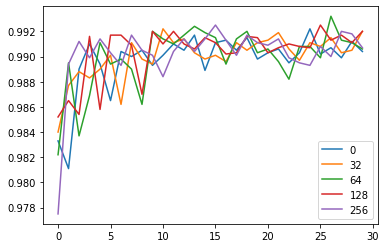

In [ ]:
try_models(models)

The best accuracy is achieves adding a hidden layer with 64 neurons, althout it is not much better that the model without a hidden layer, and it doubles the number of parameters to learn. We'll won't add a hidden layer.

## Add droput

We have a base architecture that seems to work well. Adding a dropout layer after each convolutional stack should help the model to generalize better. We'll try adding dropout with different ratios (0 to 0.7 in increments of 0.1):

In [ ]:
dropout = [i/10 for i in range(0, 8, 1)] # 0 to 0.7 in 0.1 increments
num_models = len(dropout)
models = [0] * num_models

for i, d in enumerate(dropout):

    inputs = keras.Input(shape=(28,28,1), name="inputs")
    x = resize_and_rescale(inputs)

    for f in filters:
        x = layers.Conv2D(f, 3, padding="same", activation="relu",
                        name="conv_1_"+str(f)) (x)
        x = layers.Conv2D(f, 3, padding="same", activation="relu",
                        name="conv_2_"+str(f)) (x)
        x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu",
                        name="strides_"+str(f)) (x)
        # Dropout layer after each convolution stack
        if d > 0:
            x = layers.Dropout(d, name="dropout_"+str(f)) (x)

    x = layers.Flatten(name="flatten") (x)
    outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

    name = str(d)
    models[i] = keras.Model(inputs=inputs, outputs=outputs, name=name)
    print("Model name:", models[i].name, "- Number of parameters:", models[i].count_params())

Model name: 0.0 - Number of parameters: 142538
Model name: 0.1 - Number of parameters: 142538
Model name: 0.2 - Number of parameters: 142538
Model name: 0.3 - Number of parameters: 142538
Model name: 0.4 - Number of parameters: 142538
Model name: 0.5 - Number of parameters: 142538
Model name: 0.6 - Number of parameters: 142538
Model name: 0.7 - Number of parameters: 142538


Model name: 0.0 - Accuracy (max / last) 0.99250 / 0.99090
Model name: 0.1 - Accuracy (max / last) 0.99180 / 0.99010
Model name: 0.2 - Accuracy (max / last) 0.99260 / 0.99170
Model name: 0.3 - Accuracy (max / last) 0.99350 / 0.99180
Model name: 0.4 - Accuracy (max / last) 0.99240 / 0.99190
Model name: 0.5 - Accuracy (max / last) 0.99340 / 0.99010
Model name: 0.6 - Accuracy (max / last) 0.99240 / 0.98960
Model name: 0.7 - Accuracy (max / last) 0.99150 / 0.98970


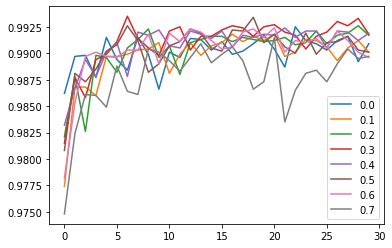

In [ ]:
try_models(models)

A dropout ratio of 0.5 seems to work the best.

## Add batch normalization

Adding a normalization layer after every convolutional stack (before dropout!) should also help improve the generalization capacity.

In [ ]:
dropout = 0.5

inputs = keras.Input(shape=(28,28,1), name="inputs")
x = resize_and_rescale(inputs)

for f in filters:
    x = layers.Conv2D(f, 3, padding="same", activation="relu",
                    name="conv_1_"+str(f)) (x)
    x = layers.Conv2D(f, 3, padding="same", activation="relu",
                    name="conv_2_"+str(f)) (x)
    x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu",
                    name="strides_"+str(f)) (x)
    
    # Batch normalization after each convolution stack
    x = layers.BatchNormalization(name="norm_"+str(f)) (x)

    x = layers.Dropout(dropout, name="dropout_"+str(f)) (x)

x = layers.Flatten(name="flatten") (x)
outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

name = "batchnorm"
model = keras.Model(inputs=inputs, outputs=outputs, name=name)
print("Model name:", model.name, "- Number of parameters:", model.count_params())

Model name: batchnorm - Number of parameters: 142922


Model name: batchnorm - Accuracy (max / last) 0.99430 / 0.99320


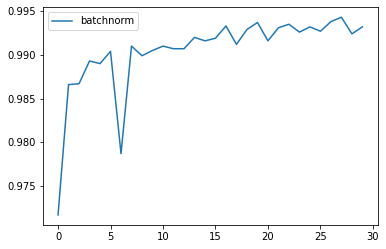

In [ ]:
models = [0]
models[0] = model
try_models(models)

Adding data augmentation should also help de model generalize.

In [ ]:
inputs = keras.Input(shape=(28,28,1), name="inputs")

# Data augmentation
x = data_augmentation(inputs)

x = resize_and_rescale(x)

for f in filters:
    x = layers.Conv2D(f, 3, padding="same", activation="relu",
                    name="conv_1_"+str(f)) (x)
    x = layers.Conv2D(f, 3, padding="same", activation="relu",
                    name="conv_2_"+str(f)) (x)
    x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu",
                    name="strides_"+str(f)) (x)
    x = layers.BatchNormalization(name="norm_"+str(f)) (x)
    x = layers.Dropout(dropout, name="dropout_"+str(f)) (x)

x = layers.Flatten(name="flatten") (x)
outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

name = "data_augmentation"
model = keras.Model(inputs=inputs, outputs=outputs, name=name)
print("Model name:", model.name, "- Number of parameters:", model.count_params())

Model name: data_augmentation - Number of parameters: 142922


Model name: data_augmentation - Accuracy (max / last) 0.99420 / 0.99140


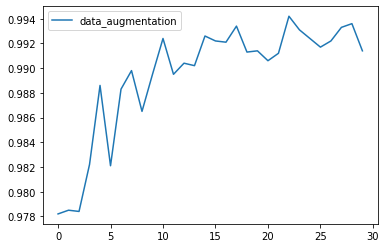

In [ ]:
models = [0]
models[0] = model
try_models(models)

## Train the final model and test with the test data set.

Now that we have a final model, we can train it more extensively and then test it on the test data set.

First, re-define the final model from scratch:

In [ ]:
inputs = keras.Input(shape=(28,28,1), name="inputs")
x = data_augmentation(inputs)
x = resize_and_rescale(x)

for f in filters:
    x = layers.Conv2D(f, 3, padding="same", activation="relu",
                    name="conv_1_"+str(f)) (x)
    x = layers.Conv2D(f, 3, padding="same", activation="relu",
                    name="conv_2_"+str(f)) (x)
    x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu",
                    name="strides_"+str(f)) (x)
    x = layers.BatchNormalization(name="norm_"+str(f)) (x)
    x = layers.Dropout(dropout, name="dropout_"+str(f)) (x)

x = layers.Flatten(name="flatten") (x)
outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

name = "final_model"
model = keras.Model(inputs=inputs, outputs=outputs, name=name)

model.summary()

Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 28, 28, 1)        0         
 al)                                                             
                                                                 
 resize_and_rescale (Sequent  (None, 28, 28, 1)        0         
 ial)                                                            
                                                                 
 conv_1_32 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv_2_32 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 strides_32 (Conv2D)         (None, 14, 14, 32)        

Train it for 100 epochs, save the best model to a file:

In [ ]:
epochs = 100

callbacks_list = [
    # save the best model
    keras.callbacks.ModelCheckpoint(
        model.name + ".h5",
        save_best_only = True,
        monitor = "val_loss",
    )
]

model.compile(optimizer = "rmsprop",
            loss = "sparse_categorical_crossentropy",
            metrics = ["accuracy"])

history = model.fit(x_train, y_train,
                    epochs = epochs,
                    batch_size = 64, 
                    validation_data = (x_val, y_val),
                    callbacks = callbacks_list,
                    verbose = 1,
                    )

Epoch 1/100
782/782 [==============================] - 9s 10ms/step - loss: 0.4080 - accuracy: 0.8754 - val_loss: 0.1375 - val_accuracy: 0.9667
Epoch 2/100
782/782 [==============================] - 8s 10ms/step - loss: 0.1751 - accuracy: 0.9491 - val_loss: 0.1493 - val_accuracy: 0.9703
Epoch 3/100
782/782 [==============================] - 8s 10ms/step - loss: 0.1409 - accuracy: 0.9586 - val_loss: 0.0772 - val_accuracy: 0.9804
Epoch 4/100
782/782 [==============================] - 8s 10ms/step - loss: 0.1219 - accuracy: 0.9656 - val_loss: 0.0632 - val_accuracy: 0.9825
Epoch 5/100
782/782 [==============================] - 8s 10ms/step - loss: 0.1106 - accuracy: 0.9676 - val_loss: 0.0603 - val_accuracy: 0.9842
Epoch 6/100
782/782 [==============================] - 8s 10ms/step - loss: 0.1001 - accuracy: 0.9714 - val_loss: 0.0660 - val_accuracy: 0.9802
Epoch 7/100
782/782 [==============================] - 9s 11ms/step - loss: 0.0891 - accuracy: 0.9734 - val_loss: 0.0586 - val_accuracy:

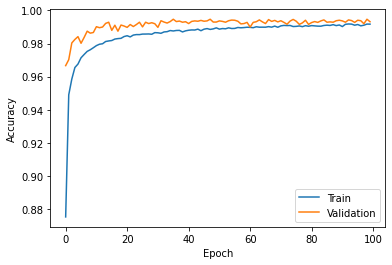

Model name: final_model - Accuracy (max): 0.99470


In [ ]:
# Plot the train and val accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(range(len(acc)), acc, label="Train")
plt.plot(range(len(acc)), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Model name: %s - Accuracy (max): %.5f" % (model.name, max(val_acc)))

Load the saved model and test it on the test data set

In [ ]:
model = keras.models.load_model("final_model.h5")
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.5f" % test_acc)

Test accuracy: 0.99320


We achieved a lower accuracy than with the first intuitive approach. Did we do something wrong?

# Compare it with model from the reference

Copy last model from "How to choose CNN Architecture MNIST" and train it to compare the results:

In [ ]:
ref_model = keras.Sequential(name="ref_model")

ref_model.add(layers.Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
ref_model.add(layers.BatchNormalization())
ref_model.add(layers.Conv2D(32,kernel_size=3,activation='relu'))
ref_model.add(layers.BatchNormalization())
ref_model.add(layers.Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
ref_model.add(layers.BatchNormalization())
ref_model.add(layers.Dropout(0.4))

ref_model.add(layers.Conv2D(64,kernel_size=3,activation='relu'))
ref_model.add(layers.BatchNormalization())
ref_model.add(layers.Conv2D(64,kernel_size=3,activation='relu'))
ref_model.add(layers.BatchNormalization())
ref_model.add(layers.Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
ref_model.add(layers.BatchNormalization())
ref_model.add(layers.Dropout(0.4))

ref_model.add(layers.Flatten())
ref_model.add(layers.Dense(128, activation='relu'))
ref_model.add(layers.BatchNormalization())
ref_model.add(layers.Dropout(0.4))
ref_model.add(layers.Dense(10, activation='softmax'))

ref_model.summary()

ref_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        ref_model.name + ".h5",
        save_best_only = True,
        monitor = "val_loss",
    )
]

history = model.fit(x_train, y_train,
                    epochs = epochs,
                    batch_size = 64, 
                    validation_data = (x_val, y_val),
                    callbacks = callbacks_list,
                    verbose = 1,
                    )

Model: "ref_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_21 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_22 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 12, 32)        25632     
                                                                 
 batch_normalization_23 (Bat  (None, 12, 12, 32)       12

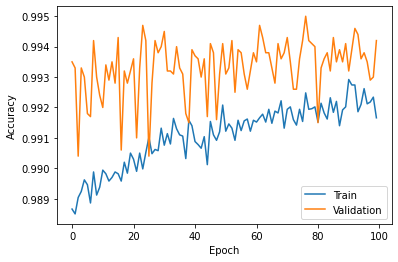

Model name: ref_model - Accuracy (max): 0.99500


In [ ]:
# Plot the train and val accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(range(len(acc)), acc, label="Train")
plt.plot(range(len(acc)), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Model name: %s - Accuracy (max): %.5f" % (ref_model.name, max(val_acc)))

In [ ]:
model = keras.models.load_model("ref_model.h5")
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.5f" % test_acc)

Test accuracy: 0.99450


This model achieves a better accuracy, although still lower than the best model of our last attemp (see part 1). The reference claims it achieves a 99.7% accuracy, wich is also much better. Maybe the problem is in the training method?

## Try again with Adam optimizer

Let's try to train our final model with the Adam optimizer, see if we obtain a different result.

Epoch 1/100
782/782 [==============================] - 8s 9ms/step - loss: 0.4260 - accuracy: 0.8688 - val_loss: 0.0853 - val_accuracy: 0.9752
Epoch 2/100
782/782 [==============================] - 7s 9ms/step - loss: 0.1761 - accuracy: 0.9473 - val_loss: 0.0744 - val_accuracy: 0.9779
Epoch 3/100
782/782 [==============================] - 7s 9ms/step - loss: 0.1374 - accuracy: 0.9571 - val_loss: 0.0588 - val_accuracy: 0.9836
Epoch 4/100
782/782 [==============================] - 7s 9ms/step - loss: 0.1155 - accuracy: 0.9655 - val_loss: 0.0646 - val_accuracy: 0.9833
Epoch 5/100
782/782 [==============================] - 7s 9ms/step - loss: 0.1088 - accuracy: 0.9667 - val_loss: 0.0625 - val_accuracy: 0.9836
Epoch 6/100
782/782 [==============================] - 7s 9ms/step - loss: 0.0950 - accuracy: 0.9715 - val_loss: 0.0487 - val_accuracy: 0.9868
Epoch 7/100
782/782 [==============================] - 7s 9ms/step - loss: 0.0912 - accuracy: 0.9730 - val_loss: 0.0591 - val_accuracy: 0.9857

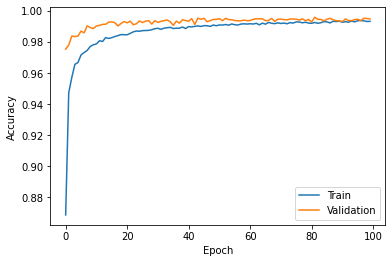

Model name: final_model_Adam - Accuracy (max): 0.99570
Test accuracy: 0.99480


In [ ]:
inputs = keras.Input(shape=(28,28,1), name="inputs")
x = data_augmentation(inputs)
x = resize_and_rescale(x)

for f in filters:
    x = layers.Conv2D(f, 3, padding="same", activation="relu",
                    name="conv_1_"+str(f)) (x)
    x = layers.Conv2D(f, 3, padding="same", activation="relu",
                    name="conv_2_"+str(f)) (x)
    x = layers.Conv2D(f, 3, padding="same", strides=2, activation="relu",
                    name="strides_"+str(f)) (x)
    x = layers.BatchNormalization(name="norm_"+str(f)) (x)
    x = layers.Dropout(dropout, name="dropout_"+str(f)) (x)

x = layers.Flatten(name="flatten") (x)
outputs = layers.Dense(10, activation="softmax", name="outputs") (x)

name = "final_model_Adam"
model = keras.Model(inputs=inputs, outputs=outputs, name=name)

callbacks_list = [
    # save the best model
    keras.callbacks.ModelCheckpoint(
        model.name + ".h5",
        save_best_only = True,
        monitor = "val_loss",
    )
]

model.compile(optimizer = "Adam",
            loss = "sparse_categorical_crossentropy",
            metrics = ["accuracy"])

history = model.fit(x_train, y_train,
                    epochs = epochs,
                    batch_size = 64, 
                    validation_data = (x_val, y_val),
                    callbacks = callbacks_list,
                    verbose = 1,
                    )

# Plot the train and val accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(range(len(acc)), acc, label="Train")
plt.plot(range(len(acc)), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Model name: %s - Accuracy (max): %.5f" % (model.name, max(val_acc)))

model = keras.models.load_model("final_model_Adam.h5")
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.5f" % test_acc)

We did achieve an improvement with the Adam optimizer (although it still is lower than the best model in part 1). We should look into this next time.

# Discussion

The process we followed to find and optimal architecture and hyperparameters seems fine, but the final model achieves a worst accuracy on the test data set than the one we constructed from intuition only on part 1. Did we miss something?

We did obtain a much simpler model (less parameters).

Also, the reference model copied from the post on which we based this procedure dind't achieve the same accuracy claimed in the post. The difference must be on the training process (or the initialization values?). We should look into this.

Finally, the final model trained with the ADAM optimizer (instead of RMSPROP) achieves a better test accuracy. We should also look into this.